In [49]:
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
colors = sns.color_palette("tab10")

from scipy.optimize import curve_fit

In [50]:
Ls = 2**np.arange(4, 10)
shots = 256
timesteps = 128
p_dict = {
    1: 0.16,
    2: 0.33,
    3: 0.418,
    4: 0.458,
    5: 0.478
}
D = 5
p = p_dict[D]

In [51]:
# Load data. Rows are x, y_mu, y_std
data_list = [np.zeros((3, int(L / 2))) for L in Ls]
logxdata = np.array([])
ydata = np.array([])
stddata = np.array([])
for i, L in enumerate(Ls):
    depth = L // 2
    try:
        filename = "data/{}_{}_{}_{}_{}_entropies_all.npy".format(L, depth, shots * timesteps, p, D)
        data_list[i] = np.load(filename)[:, 1::2]*np.log(2) # hacky solution; change later
        if i > 2:
            logxdata = np.append(logxdata, np.log(data_list[i][0, :]))
            ydata = np.append(ydata, data_list[i][1, :])
            stddata = np.append(stddata, data_list[i][2, :])
    except:
        print("No data for L = {}".format(L))

No data for L = 256
No data for L = 512


In [53]:
def S(xilog, c):
    return -0.53 * xilog + c
end = logxdata.shape[0] // 2
fit_result = curve_fit(S, logxdata[end:], ydata[end:], p0 = [1], sigma = stddata[end:])
h = 0.53
c = fit_result[0][0]

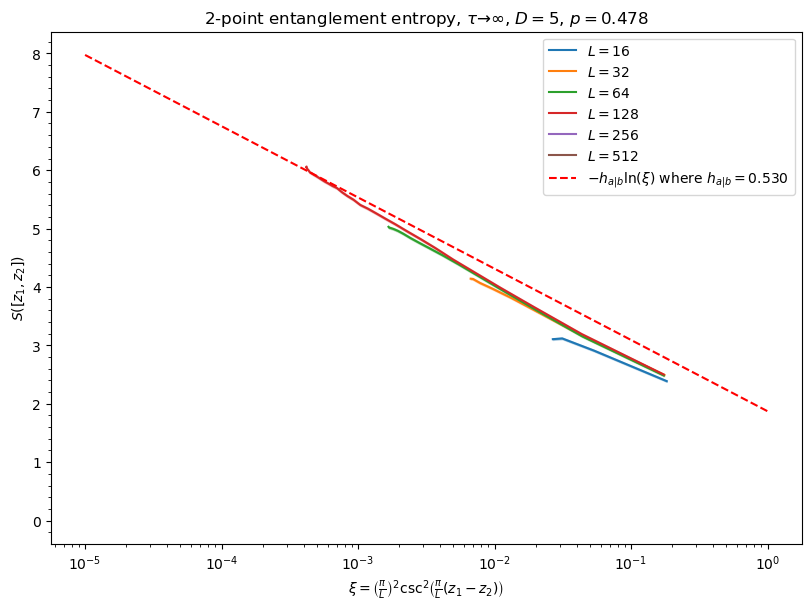

In [54]:
plt.subplots(figsize = (8, 6), layout = "constrained")

for i, L in enumerate(Ls):
    stub = "figs/{}_{}_{}_".format(shots * timesteps, p, D)
    data = data_list[i]
    x = data[0, :]
    mu = data[1, :]
    std = data[2, :]
    plt.plot(x, mu, label = "$L={}$".format(L), color = colors[i])
    plt.fill_between(x, mu - std, mu + std, color = colors[i], alpha = 0.3)

xis = np.logspace(-5, 0, 1000)
Sxis = -h * np.log(xis) + c
plt.plot(xis, Sxis, linestyle = "--", color = "red", label = "$-h_{{a|b}}\ln(\\xi)$ where $h_{{a|b}}={:.3f}$".format(h))

plt.xlabel(r"$\xi=\left(\frac{\pi}{L}\right)^2\csc^2\left(\frac{\pi}{L}(z_1-z_2)\right)$")
plt.ylabel(r"$S([z_1,z_2])$")
plt.title("2-point entanglement entropy, $\\tau\\to\infty$, $D={}$, $p={}$".format(D, p))
plt.legend(loc = "upper right")
plt.xscale('log')
plt.minorticks_on()
# plt.savefig(stub + "entropies.png")